<a href="https://colab.research.google.com/github/nightted/ML-LeeHongYi-HW/blob/master/HW9_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optimizer
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from PIL import Image

In [ ]:
# preparing data
!gdown --id '1BZb2AqOHHaad7Mo82St1qTBaXo_xtcUc' --output trainX.npy 
!gdown --id '152NKCpj8S_zuIx3bQy0NN5oqpvBjdPIq' --output valX.npy 
!gdown --id '1_hRGsFtm5KEazUg2ZvPZcuNScGF-ANh4' --output valY.npy 
!mkdir checkpoints
!ls

Downloading...
From: https://drive.google.com/uc?id=1BZb2AqOHHaad7Mo82St1qTBaXo_xtcUc
To: /content/trainX.npy
26.1MB [00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=152NKCpj8S_zuIx3bQy0NN5oqpvBjdPIq
To: /content/valX.npy
100% 1.54M/1.54M [00:00<00:00, 48.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_hRGsFtm5KEazUg2ZvPZcuNScGF-ANh4
To: /content/valY.npy
100% 4.13k/4.13k [00:00<00:00, 12.7MB/s]
checkpoints  drive  sample_data  trainX.npy  valX.npy  valY.npy


In [ ]:
def loading_img(path):

  return np.load(path)

In [ ]:
imgs = loading_img('/content/trainX.npy')
imgs.shape

(8500, 32, 32, 3)

In [ ]:
 # normalizes and transpose the shape of data 
def preprocess_imgs(imgs):
  transpose_imgs = np.transpose( imgs , (0, 3 ,1 ,2)) #adjust shape of imgs from (8500, 32, 32, 3) to (8500, 3, 32, 32)
  transpose_imgs = (transpose_imgs / 255) * 2 - 1
  transpose_imgs = transpose_imgs.astype(np.float32)

  return transpose_imgs 

class Datasets(Dataset) :

  def __init__(self , imgs ):
    self.imgs = imgs
  
  def __len__(self) :
    return len(self.imgs)
  
  def __getitem__(self , idx): # __getitem__ method can refer to https://blog.csdn.net/yuan_j_y/article/details/9317817
    return self.imgs[idx]

In [ ]:
# prepare training imgs
imgs_data = preprocess_imgs(imgs)
img_dataset = Datasets(imgs_data)

In [ ]:
# Define AE model 
class AutoEncoder(nn.Module):

  def __init__(self):
    super(AutoEncoder,self).__init__()

    # encoder structure 
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 64, 3, stride=1, padding=1), # shape : [64 , 32 , 32]
      nn.ReLU(True),
      nn.MaxPool2d(2), # shape : [64 , 16 , 16]
      nn.Conv2d(64, 128, 3, stride=1, padding=1), # shape : [128 , 16 , 16]
      nn.ReLU(True),
      nn.MaxPool2d(2), # shape : [128 , 8 , 8]
      nn.Conv2d(128, 256, 3, stride=1, padding=1), # shape : [256 , 8 , 8]
      nn.ReLU(True),
      nn.MaxPool2d(2) # shape : [256 , 4 , 4]

    )

    # kernel size of transpose = b - (a-1)*s , a/b is input/output size , s is stride
    self.decoder = nn.Sequential( 
      nn.ConvTranspose2d(256, 128, 5, stride=1),  # shape : [128 , 8 , 8]  , k = 8 - (4-1) = 5 
      nn.ReLU(True),
      nn.ConvTranspose2d(128, 64, 9, stride=1), # shape : [64 , 16 , 16] , k = 16 - (8-1) = 9
      nn.ReLU(True),
      nn.ConvTranspose2d(64, 3, 17, stride=1), # shape : [3 , 32 , 32] , k = 32 - (16-1) = 17
      nn.Tanh()
    )

  def forward(self , input ):
    
    encode_vec = self.encoder(input)
    decode_vec = self.decoder(encode_vec)

    return encode_vec , decode_vec

In [ ]:
# training setup
def train_setup(dataset , 
        batch_size = 64,
        Epochs = 100,
        lr = 0.00001,
        weight_decay = 0.00001,
        device = 'cuda' if torch.cuda.is_available else 'cpu'):

  img_dataloader = DataLoader(dataset , batch_size = batch_size , shuffle = True)
  model = AutoEncoder().to(device)
  train_optimizer = optimizer.Adam(model.parameters() , lr = lr , weight_decay = weight_decay)
  loss_func = nn.MSELoss()

  return model , img_dataloader , train_optimizer , loss_func 

In [ ]:
# training 
def train_process( model , img_dataloader , train_optimizer , loss_function  ):

  model.train()
  train_loss_record = []
  for epoch in range(Epochs):
    losses = 0
    for idx , img_data in enumerate(img_dataloader):
      
      img_data = img_data.to(device)
      encode_vec , decode_vec = model(img_data)
      loss = loss_func(img_data , decode_vec.to(device))
      loss.backward()
      train_optimizer.step()
      train_optimizer.zero_grad() # always forgot to do this XDD

      if epoch % 10 == 0:
        torch.save(model.state_dict() , f'/content/drive/My Drive/Colab Notebooks/LeeHongYi HW/AutoEncoder_mixmodel_checkpoint_{epoch}')

      losses += loss
    print(f' now in epoch {epoch+1} , the losses is {losses} . ')
    train_loss_record.append(losses)

  torch.save(model.state_dict() , f'/content/drive/My Drive/Colab Notebooks/LeeHongYi HW/AutoEncoder_mixmodel_checkpoint_last')

  return model , train_loss_record

In [ ]:
def plot_scatter(feat, label, savefig=None):
    """ Plot Scatter Image.
    Args:
      feat: the (x, y) coordinate of clustering result, shape: (9000, 2)
      label: ground truth label of image (0/1), shape: (9000,)
    Returns:
      None
    """
    X = feat[:, 0]
    Y = feat[:, 1]
    plt.scatter(X, Y, c = label)
    plt.legend(loc='best')
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    return

def cal_acc(gt, pred):
    """ Computes categorization accuracy of our task.
    Args:
      gt: Ground truth labels (9000, )
      pred: Predicted labels (9000, )
    Returns:
      acc: Accuracy (0~1 scalar)
    """
    # Calculate Correct predictions
    correct = np.sum(gt == pred)
    acc = correct / gt.shape[0]

    # 因為不知道某種 label 的 datapoints 到底是"屬於cluster的哪類" , 所以取兩類當中具有的最大辨識度
    return max(acc, 1-acc)

In [ ]:
def inference(data , model , batch_size = 256):
  
  data = preprocess_imgs(data)
  dataset = Datasets(data)
  dataloader = DataLoader(dataset , batch_size= batch_size , shuffle=False)
  latent_vecs = None 
  for idx , data in enumerate(dataloader):
    data = data.to(device)
    encode_vec , decode_vec = model(data)
    if idx == 0:
      latent_vecs = encode_vec.view(decode_vec.size()[0] , -1 ).cpu().detach().numpy()
    else :
      latent_vecs = np.concatenate( ( latent_vecs ,encode_vec.view(decode_vec.size()[0] , -1 ).cpu().detach().numpy() ) , axis = 0)
  
  assert latent_vecs.shape == (dataset.__len__() , 256*4*4 )

  return latent_vecs

def predict(latent_vecs):

  # First Dimension Reduction
  transformer = KernelPCA(n_components=200, kernel='rbf', n_jobs=-1)
  kpca = transformer.fit_transform(latent_vecs)
  print('First Reduction Shape:', kpca.shape)

  # Second Dimesnion Reduction
  X_embedded = TSNE(n_components=2).fit_transform(kpca)
  print('Second Reduction Shape:', X_embedded.shape)

  # Clustering label predict
  pred = MiniBatchKMeans(n_clusters=2, random_state=0).fit(X_embedded)
  pred = [int(i) for i in pred.labels_]
  pred = np.array(pred) # save as np for comparison convenience

  return pred, X_embedded
  

In [ ]:
# load best model
model = AutoEncoder().cuda()
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/LeeHongYi HW/AutoEncoder_model_checkpoint_last'))
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(9, 9), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 3, kernel_size=(17, 17), stride=(1, 1))
    (5): Tanh()
  )
)

First Reduction Shape: (500, 200)


No handles with labels found to put in legend.


Second Reduction Shape: (500, 2)
The clustering accuracy is: 0.748
The clustering result:


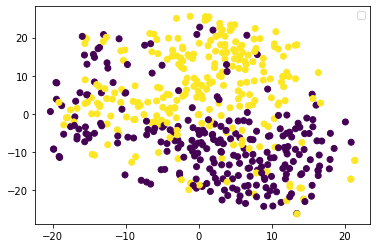

In [ ]:
valX = np.load('valX.npy')
valY = np.load('valY.npy')

latents = inference(valX, model)
pred_from_latent, emb_from_latent = predict(latents)
acc_latent = cal_acc(valY, pred_from_latent)
print('The clustering accuracy is:', acc_latent)
print('The clustering result:')
plot_scatter(emb_from_latent, valY, savefig='p1_baseline.png')

In [ ]:
# validation + training data to train
img_train = loading_img('/content/trainX.npy')
img_validation = loading_img('/content/valX.npy')
img_data_mix = np.concatenate( (img_train , img_validation) , axis = 0 )
print(img_data_mix.shape)

(9000, 32, 32, 3)


In [ ]:
# validation + training data to train
img_data_mix = preprocess_imgs(img_data_mix)
mix_dataset = Datasets(img_data_mix)
model , img_dataloader , train_optimizer , loss_function  = train_setup(mix_dataset)
model , train_loss_record = train_process( model , img_dataloader , train_optimizer , loss_function  )

 now in epoch 1 , the losses is 31.212846755981445 . 
 now in epoch 2 , the losses is 24.502702713012695 . 
 now in epoch 3 , the losses is 20.193052291870117 . 
 now in epoch 4 , the losses is 17.471656799316406 . 
 now in epoch 5 , the losses is 15.789352416992188 . 
 now in epoch 6 , the losses is 14.750123977661133 . 
 now in epoch 7 , the losses is 14.041296005249023 . 
 now in epoch 8 , the losses is 13.49959659576416 . 
 now in epoch 9 , the losses is 13.067206382751465 . 
 now in epoch 10 , the losses is 12.68159008026123 . 
 now in epoch 11 , the losses is 12.355345726013184 . 
 now in epoch 12 , the losses is 12.094058990478516 . 
 now in epoch 13 , the losses is 11.838266372680664 . 
 now in epoch 14 , the losses is 11.616640090942383 . 
 now in epoch 15 , the losses is 11.40603256225586 . 
 now in epoch 16 , the losses is 11.199481964111328 . 
 now in epoch 17 , the losses is 11.021794319152832 . 
 now in epoch 18 , the losses is 10.841402053833008 . 
 now in epoch 19 , the

In [ ]:
# load best mix_model 
model = AutoEncoder().cuda()
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/LeeHongYi HW/AutoEncoder_mixmodel_checkpoint_last'))
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(9, 9), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 3, kernel_size=(17, 17), stride=(1, 1))
    (5): Tanh()
  )
)

First Reduction Shape: (500, 200)


No handles with labels found to put in legend.


Second Reduction Shape: (500, 2)
The clustering accuracy is: 0.738
The clustering result:


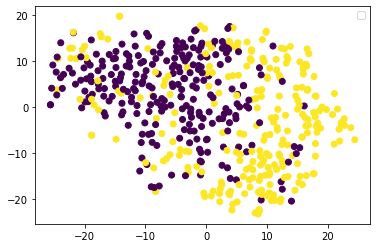

In [ ]:
valX = np.load('valX.npy')
valY = np.load('valY.npy')

latents = inference(valX, model)
pred_from_latent, emb_from_latent = predict(latents)
acc_latent = cal_acc(valY, pred_from_latent)
print('The clustering accuracy is:', acc_latent)
print('The clustering result:')
plot_scatter(emb_from_latent, valY, savefig='p1_baseline.png')

No handles with labels found to put in legend.


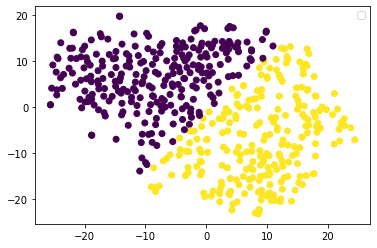

In [ ]:
plot_scatter(emb_from_latent, pred_from_latent, savefig='p1_baseline.png')